In [1]:
import h5py, sys, os
import numpy as np
from scipy import ndimage
import scipy
from matplotlib import pyplot as plt
from matplotlib import animation
from datetime import datetime
from matplotlib import colors
print(os.getcwd())

# PyDMD imports
from pydmd import DMD, MrDMD, FbDMD, SpDMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D, plot_eigs_mrdmd

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves


In [2]:
print(base_dir)

#Load simulation data
u, w, b, phi, zeta, times = load_data('u_xz', 'w_xz', 'th1_xz', 'th2_xz', 'omegaY_xz')
N2t = np.gradient(np.gradient(b, gzf, axis=1), times, axis=0)
b -= b[0] # subtract initial profile so b is perturbation b
NSAMP = len(times)

print(w.shape)

times, t0_idx = calibrate_time(save_dir, times)

/store/ATMOS/cwp29/data/waves/wide/hres/N_1/
Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nlwf_xz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>


/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


(156, 513, 1024)
Plume penetration occured at t=2.3545


In [3]:
buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
md['SAVE_STATS_DT'] *= buoy_per
md['SAVE_STATS_DT_FINE'] *= buoy_per
tend_idx = len(times)-1
tstart_idx = get_index(md['FINE_RES_TIME']*buoy_per, times)
print(md['TIME_LIMIT'], md['FINE_RES_TIME']*buoy_per)
print("Time range: {0:.2f} to {1:.2f} s".format(times[tstart_idx], times[tend_idx]))
print("equal to {0:.2f} buoyancy periods".format((times[tend_idx]-times[tstart_idx])/buoy_per))

#zplot = 0.4
zmin = 0.15
zmax = 0.45
zmin_idx = get_index(zmin, gzf)
zmax_idx = get_index(zmax, gzf)

zplot = 0.35 # must be smaller than z_max
xplot = 0.75
assert zplot <= zmax


phi_contour = 1e-3
xlims = (0.2, 0.8)
clim = 1e-1

# Choose data window
u = u[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
w = w[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
b = b[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
zeta = zeta[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
N2t = N2t[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
phi = phi[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]
times = times[tstart_idx:tend_idx+1]

# Filter out timesteps
filter_step = 1
times = times[::filter_step]
times_trunc = np.concatenate(([times[0]-filter_step*md['SAVE_STATS_DT_FINE']], times))
ntimes = len(times)

print(len(times))

phi_snapshots = [phi[::filter_step][i] for i in range(len(times))]

X, Y = np.meshgrid(gx, gz[zmin_idx-1:zmax_idx+1])
Xf, Yf = np.meshgrid(gxf, gzf[zmin_idx:zmax_idx+1])

25.2 6.3
Time range: 6.30 to 25.07 s
equal to 2.98 buoyancy periods
150


In [4]:
# Set up FT arrays
freq_m = np.fft.fftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']
wavenumber_z = -np.fft.fftfreq(w.shape[1])*2*np.pi*md['Nz']/md['LZ']
wavenumber_x = -np.fft.fftfreq(w.shape[2])*2*np.pi*md['Nx']/md['LX']

In [5]:
# Pre-processing & data array setup
data_pack = [u, w, N2t, zeta]

plot_idx = 3

for i in range(len(data_pack)):
    var = data_pack[i]
    
    # Gaussian filtering
    sigma = 2
    var_filtered = np.zeros_like(var)
    for j in range(len(var)):
        var_filtered[j] = ndimage.gaussian_filter(var[j], sigma)

    # Hilbert transform
    # Dimension sizes from large to small: x, z, t

    # FFT in x
    waves_x = np.fft.fft(var_filtered, axis=2)
    waves_x[:, :, np.abs(wavenumber_x) >= 1000] = 0 #remove small wavelength oscillations
    waves_filtered = np.fft.ifft(waves_x, axis=2)

    # FFT in z
    waves_z = np.fft.fft(waves_filtered, axis=1)
    #waves_z[:, wavenumber_z >= 0, :] = 0 #remove upward propagating waves
    waves_filtered = np.fft.ifft(waves_z, axis=1)
    
    waves_t = np.fft.fft(waves_filtered, axis=0)
    waves_t[freq_m <= 0, :, :] = 0 # zero out negative freq.
    waves_t *= 2 # preserve energy
    waves_filtered = np.real(np.fft.ifft(waves_t, axis=0))

    data_pack[i] = waves_filtered

data = np.array(data_pack)
print(data.shape)
data = np.moveaxis(data, 0, -1)
print(data.shape)

#data = np.concatenate(tuple(data_pack), axis=1)
#print(data_pack[0].shape, data.shape)
#unpacked_data = np.array_split(data, len(data_pack), axis=1)

(4, 150, 257, 1024)
(150, 257, 1024, 4)


(257, 1024, 4)
150


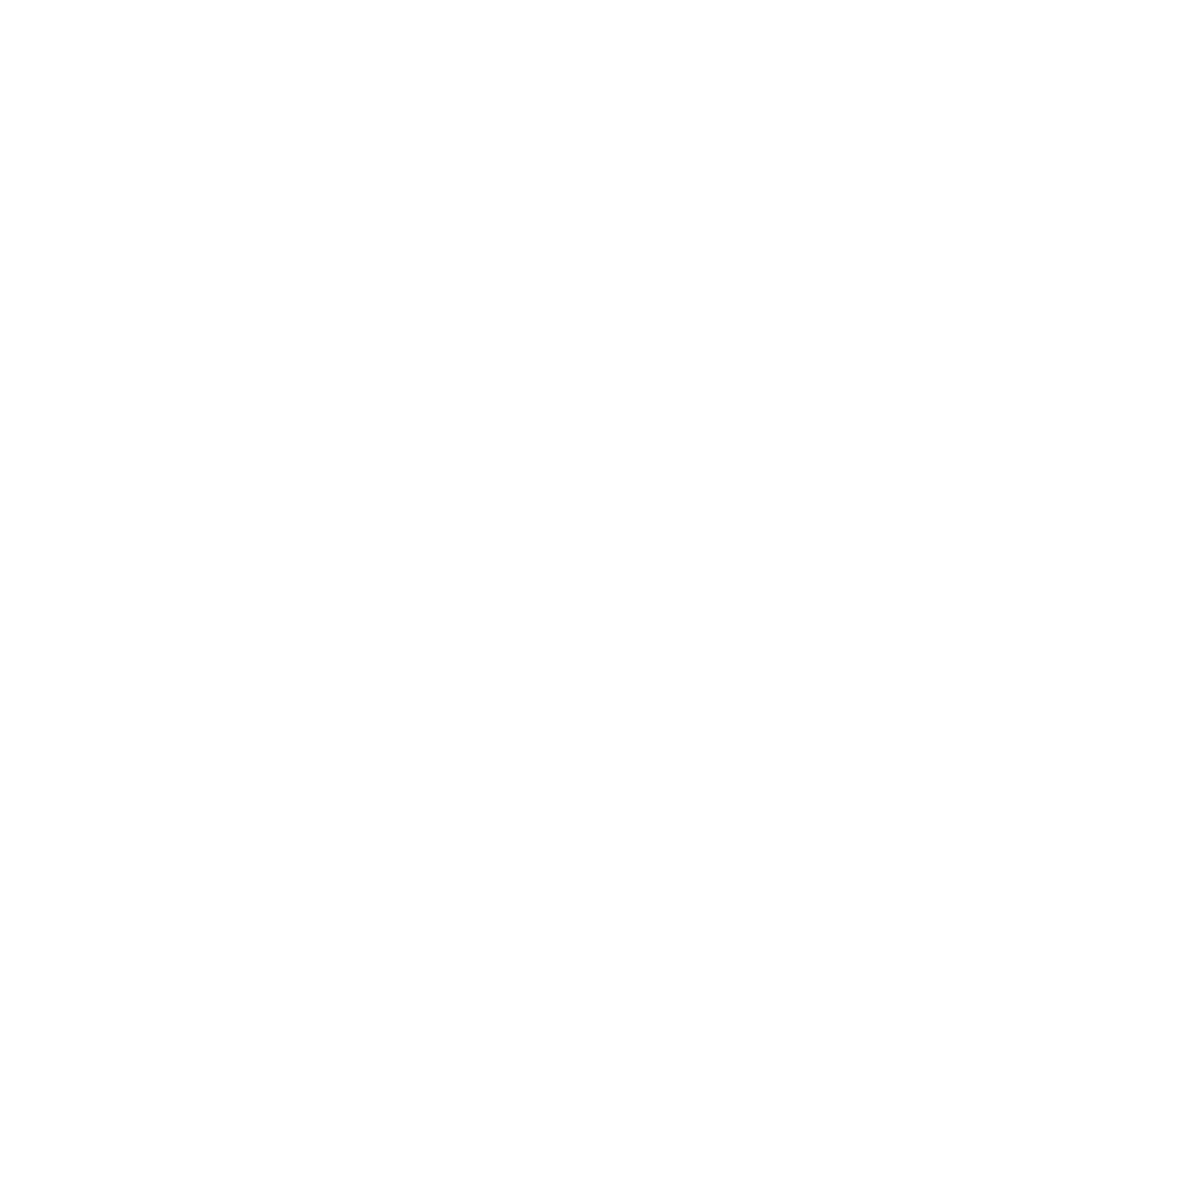

In [6]:
fig = plt.figure(figsize=(12,12))

snapshots = [data[::filter_step][i] for i in range(len(times))]
print(snapshots[0].shape)
print(len(snapshots))

# Rogue test idea
#snapshots = [snapshots[i] * np.where(np.mean(phi_snapshots,axis=0) >= phi_contour, 0.01, 1) for i in range(len(snapshots))]

#ncol = 4
#if len(snapshots) % ncol != 0:
    #rnum = len(snapshots)//ncol + 1
#else:
    #rnum = len(snapshots)//ncol

#plot_snapshots = np.array_split(np.array(snapshots), len(data_pack), axis=1)[plot_idx]
#for id_subplot, snapshot in enumerate(snapshots, start=1):
    #plt.subplot(rnum, ncol, id_subplot)
    #plt.pcolormesh(X, Y, snapshot[:,:,plot_idx], vmin=-clim, vmax=clim)
    #plt.contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='w')
    #plt.xlim(*xlims)
    #plt.gca().set_aspect(1)

In [7]:
dmd = BOPDMD(svd_rank=0, eig_constraints={"imag", "conjugate_pairs"}, eig_sort="imag")
dmd.fit(snapshots, times)

/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2338658385653454.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


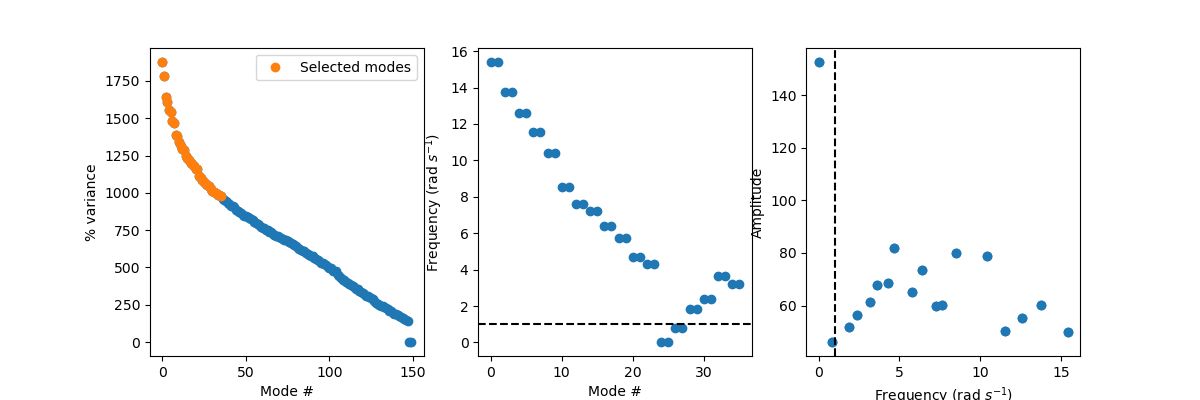

In [8]:
fig3, ax3 = plt.subplots(1,3, figsize=(12, 4))
#ax3[1].plot(np.abs(dmd.frequency*2*np.pi/(filter_step*md['SAVE_STATS_DT_FINE'])), "o")
ax3[2].plot(np.abs(np.imag(dmd.eigs)), dmd.amplitudes, "o")
ax3[2].set_xlabel(r"Frequency (rad $s^{-1}$)")
ax3[2].axvline(np.sqrt(md['N2']), color='k', linestyle='--')
ax3[2].set_ylabel("Amplitude")

ax3[1].plot(np.abs(np.imag(dmd.eigs)), "o")
ax3[1].set_xlabel("Mode #")
ax3[1].set_ylabel(r"Frequency (rad $s^{-1}$)")
ax3[1].axhline(np.sqrt(md['N2']), color='k', linestyle='--')

ax3[0].set_ylabel("% variance")
ax3[0].set_xlabel("Mode #")
ax3[0].plot(scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T), "o")
ax3[0].plot(scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T)[:len(dmd.eigs)], "o", label="Selected modes")
ax3[0].legend()
plt.show()

In [9]:
#fig4 = plt.figure(figsize=(12, 12))
##TODO: turn off x and y axis labels
#for id_subplot, snapshot in enumerate(dmd.reconstructed_data.T, start=1):
    #plt.subplot(rnum, ncol, id_subplot)
    #plt.pcolormesh(
        #X, Y, snapshot.reshape(snapshots[0].shape).real[:,:,plot_idx], vmin=-clim, vmax=clim,
        #cmap='bwr'
    #)
    #plt.contour(Xf, Yf, phi_snapshots[id_subplot-1], levels=[phi_contour], colors='k')
    #plt.xlim(*xlims)
    #plt.gca().set_aspect(1)

In [10]:
#plot_eigs(dmd, figsize=(8, 8))

In [11]:
# Plot ALL modes
modes = np.moveaxis(dmd.modes, -1, 0)
nmodes = len(modes)

#ncol_modes = 4
#if nmodes % ncol_modes != 0:
    #rnum_modes = nmodes//ncol_modes + 1
#else:
    #rnum_modes = nmodes//ncol_modes

#fig6 = plt.figure(figsize=(12, 12))
#for id_subplot, snapshot in enumerate(modes, start=1):
    #plt.subplot(rnum_modes, ncol_modes, id_subplot)
    #plt.pcolormesh(X, Y, snapshot.reshape(snapshots[0].shape).real[:,:,plot_idx], vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')
    #plt.contour(Xf, Yf, np.mean(phi_snapshots, axis=0), levels=[phi_contour], colors='k')
    #plt.xlim(*xlims)
    #plt.gca().set_title("Mode {0}, omega={1:.2f}".format(id_subplot-1, np.imag(dmd.eigs)[id_subplot-1]))
    #plt.gca().set_aspect(1)

There are 18 unique modes.


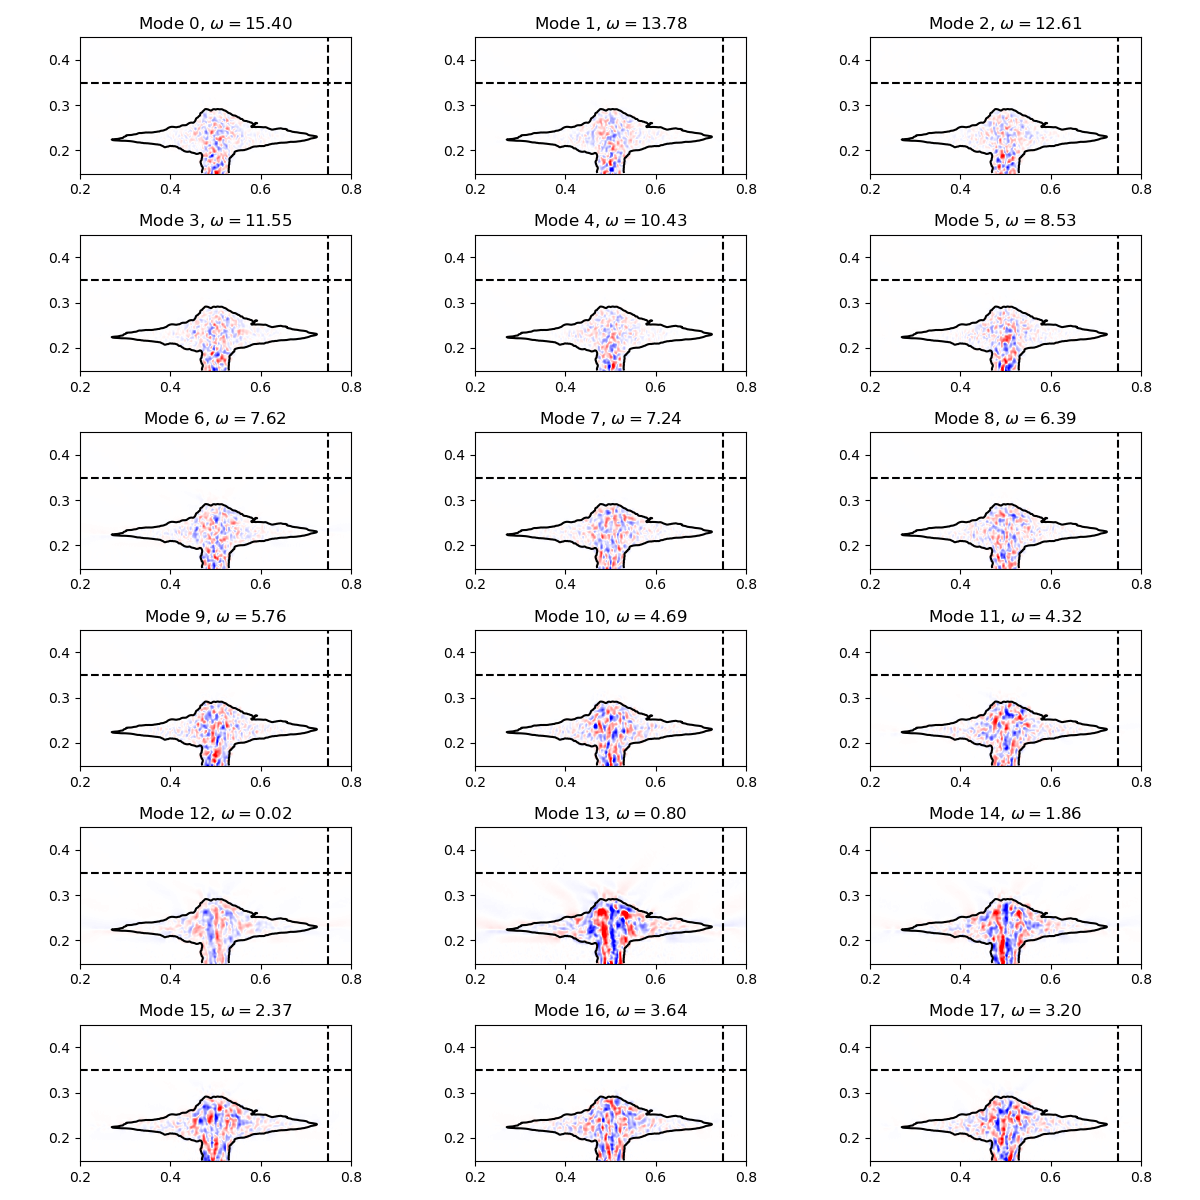

In [12]:
# Plot unique modes
modes = np.moveaxis(dmd.modes, -1, 0)
nmodes = len(modes)

#mode_freqs = np.abs(dmd.frequency*2*np.pi/(filter_step*md['SAVE_STATS_DT_FINE']))
mode_freqs = np.abs(np.imag(dmd.eigs))
nmodes_unique = len(np.unique(np.round(mode_freqs, decimals=4)))
print("There are {0} unique modes.".format(nmodes_unique))

ncol_modes = 3
if nmodes_unique % ncol_modes != 0:
    rnum_modes = nmodes_unique//ncol_modes + 1
else:
    rnum_modes = nmodes_unique//ncol_modes

fig7 = plt.figure(figsize=(12, 12))

mode_num = -1
plotted_freqs = []
for i in range(len(modes)):
    snapshot = modes[i]
    if (i == 0) or (round(mode_freqs[i],4) not in plotted_freqs):
        plotted_freqs.append(round(mode_freqs[i],4))
        mode_num += 1
        plt.subplot(rnum_modes, ncol_modes, mode_num+1)
        plt.pcolormesh(X, Y, snapshot.reshape(snapshots[0].shape).real[:,:,plot_idx], vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')
        plt.contour(Xf, Yf, np.mean(phi_snapshots, axis=0), levels=[phi_contour], colors='k')
        plt.axvline(xplot, color='k', linestyle='--')
        plt.axhline(zplot, color='k', linestyle='--')
        plt.xlim(*xlims)
        plt.gca().set_title(r"Mode {0}, $\omega = {1:.2f}$".format(mode_num, mode_freqs[i]))
        plt.gca().set_aspect(1)

plt.tight_layout()
#save_fig(fig7, '/home/cwp29/tmp/unique_modes.jpg', dpi=300)

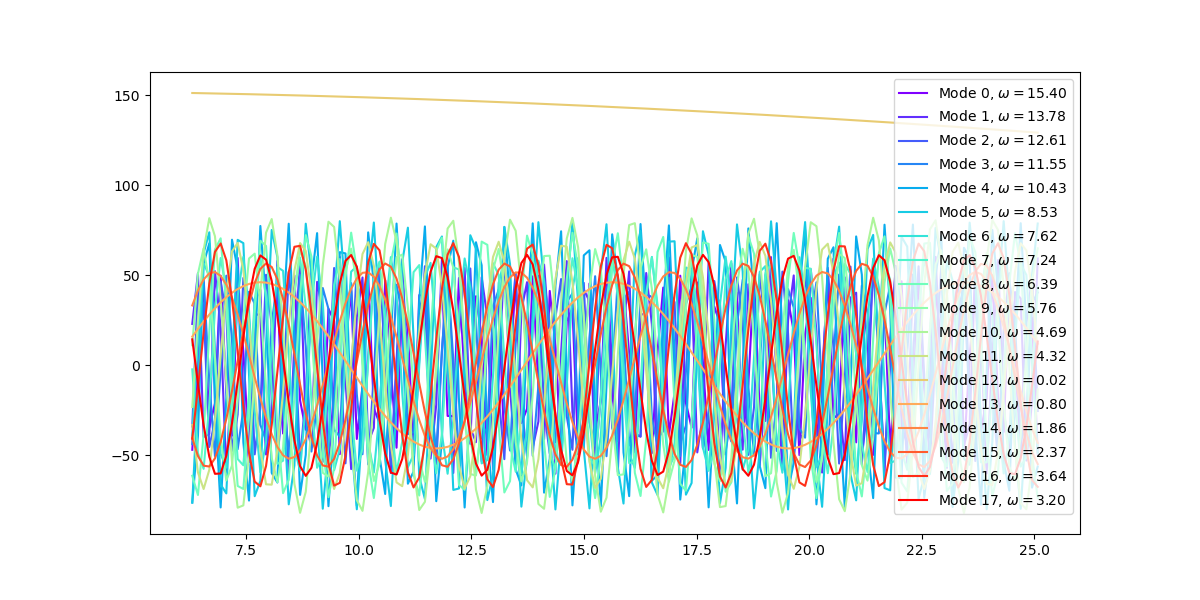

In [13]:
# Plot modes over time
fig8 = plt.figure(figsize=(12,6))
cols = plt.cm.rainbow(np.linspace(0, 1, nmodes_unique))
#for n, line in enumerate(dmd.dynamics.real):
    #plt.plot(dmd.dmd_timesteps*md['SAVE_STATS_DT_FINE']*filter_step,
    #plt.plot(times, line, label = "Mode {0}".format(n), color=cols[n])

mode_num = -1
plotted_freqs = []
for i in range(len(modes)):
    line = dmd.dynamics.real[i]
    if (i == 0) or (round(mode_freqs[i],4) not in plotted_freqs):
        plotted_freqs.append(round(mode_freqs[i],4))
        mode_num += 1
        plt.plot(times, line, label=r"Mode {0}, $\omega = {1:.2f}$".format(mode_num, mode_freqs[i]), color=cols[mode_num])
        
plt.legend()

Mode 0, $\omega = 15.40$
[0.2099 0.1278 0.0429]
Mode 1, $\omega = 13.78$
[0.7078 0.4479 0.1965]
Mode 2, $\omega = 12.61$
[0.2879]
Mode 3, $\omega = 11.55$
[0.5152]
Mode 4, $\omega = 10.43$
[0.1965]
Mode 5, $\omega = 8.53$
[0.6697 0.2879]
Mode 6, $\omega = 7.62$
[0.4479 0.2879 0.1486]
Mode 7, $\omega = 7.24$
[0.8746 0.3393 0.7248 0.2059]
Mode 8, $\omega = 6.39$
[0.5152]
Mode 9, $\omega = 5.76$
[0.7406 0.3139 0.5742 0.2059]
Mode 10, $\omega = 4.69$
[0.8556 0.3139]
Mode 11, $\omega = 4.32$
[0.6697 0.4479 0.1965]
Mode 12, $\omega = 0.02$
[0.5602 0.3517 0.2199]
Mode 13, $\omega = 0.80$
[0.6697 0.5152 0.2879]
Mode 14, $\omega = 1.86$
[0.5152 0.2879]
Mode 15, $\omega = 2.37$
[0.7078 0.2879 0.5152 0.1775]
Mode 16, $\omega = 3.64$
[0.7688 0.5742 0.372  0.1965]
Mode 17, $\omega = 3.20$
[0.7406 0.5742 0.1965]


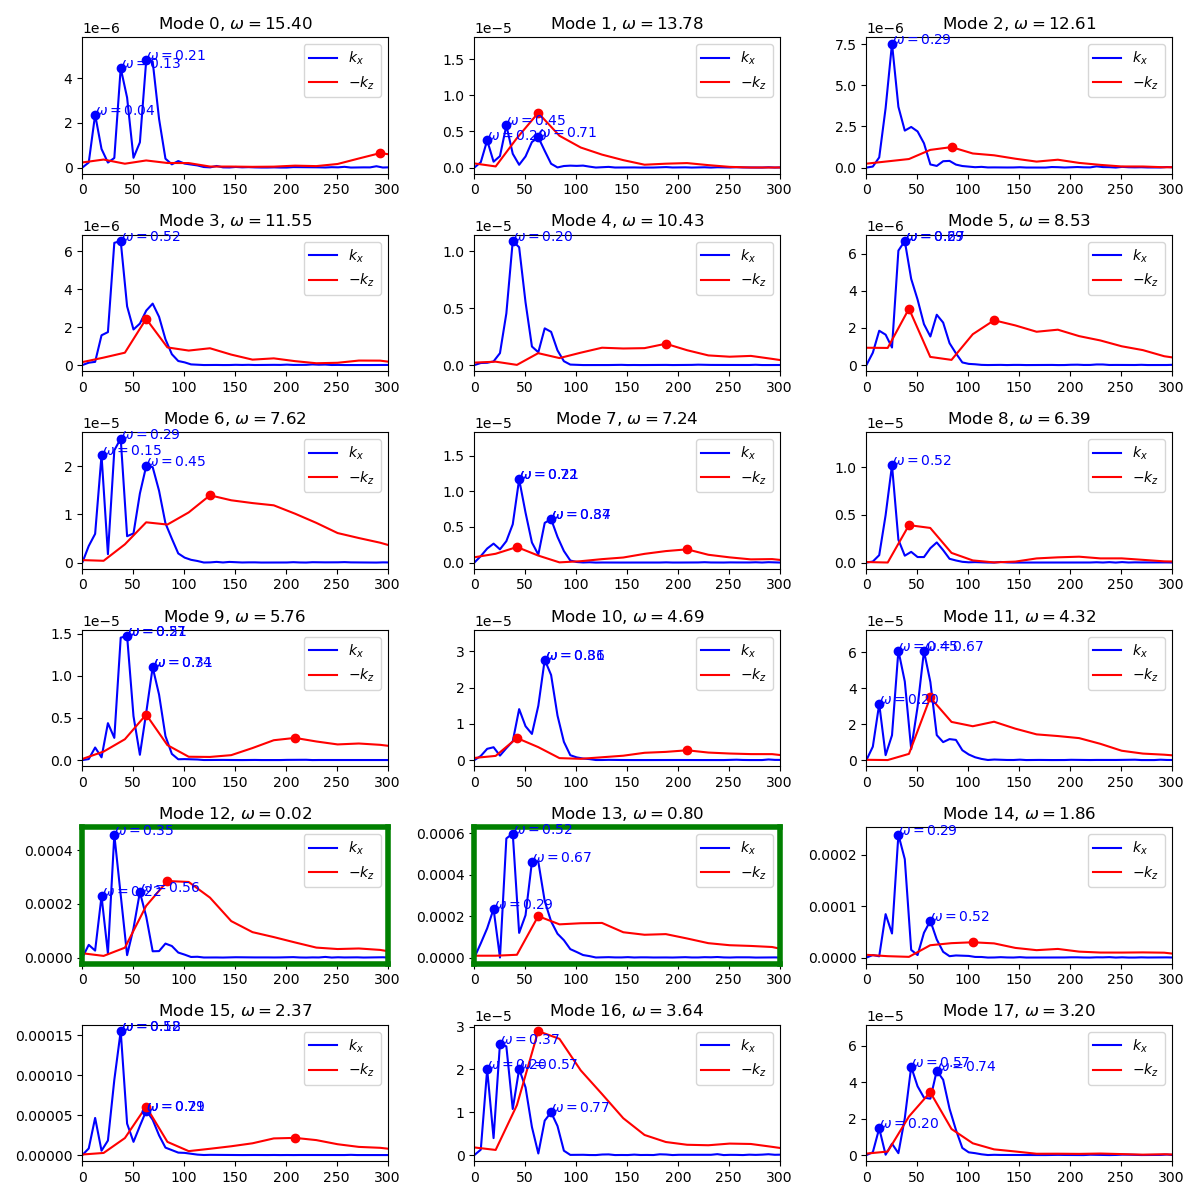

In [14]:
# Wavenumber spectra and frequency calculation for unique modes
modes = modes.reshape((nmodes, *snapshots[0].shape))

fig7 = plt.figure(figsize=(12, 12))

N = np.sqrt(md['N2'])

mode_num = -1
plotted_freqs = []
wave_freqs = []
for i in range(len(modes)):
    snapshot = modes[i]
    if (i == 0) or (round(mode_freqs[i],4) not in plotted_freqs):
        plotted_freqs.append(round(mode_freqs[i],4))
        mode_num += 1
        plt.subplot(rnum_modes, ncol_modes, mode_num+1)
        
        plt.gca().set_title(r"Mode {0}, $\omega = {1:.2f}$".format(mode_num, mode_freqs[i]))

        kx_spectrum, kxs = wavenumber_spectrum(snapshot[get_index(zplot, gzf[zmin_idx:zmax_idx+1]), :, plot_idx], md['LX']/md['Nx'], oneD=True)
        kz_spectrum, kzs = wavenumber_spectrum(snapshot[:, get_index(xplot, gxf), plot_idx], md['LZ']/md['Nz'], oneD=True)

        kzs *= -1 # flip for convenience
        
        plt.plot(kxs, kx_spectrum, color='b', label=r"$k_x$")
        plt.plot(kzs, kz_spectrum, color='r', label=r"$-k_z$")
        plt.xlim(0, 300)

        kxs_pos = kxs[kxs > 0]
        kzs_pos = kzs[kzs > 0]
        kx_pos_spectrum = kx_spectrum[kxs > 0]
        kz_pos_spectrum = kz_spectrum[kzs > 0]

        kx_peaks, kx_props = scipy.signal.find_peaks(kx_pos_spectrum, prominence=0.25*np.max(kx_pos_spectrum))
        kz_peaks, kz_props = scipy.signal.find_peaks(kz_pos_spectrum, prominence=0.25*np.max(kz_pos_spectrum))
        plt.plot(kxs_pos[kx_peaks], kx_pos_spectrum[kx_peaks], 'o', color='b')
        plt.plot(kzs_pos[kz_peaks], kz_pos_spectrum[kz_peaks], 'o', color='r')

        omegas = []
        for px in kx_peaks:
            for pz in kz_peaks:
                kx_c = kxs_pos[px]
                kz_c = kzs_pos[pz]
                omegas.append(N*np.sqrt(kx_c*kx_c/(kz_c*kz_c + kx_c*kx_c)))
                plt.annotate(r"$\omega = {0:.2f}$".format(N*np.sqrt(kx_c*kx_c/(kz_c*kz_c + kx_c*kx_c))), (kx_c, kx_pos_spectrum[px]), color='b')
        omega_c = 0
        omegas = np.array(omegas)
        wave_freqs.append(np.round(omegas, 4))
        plt.legend()
        print(r"Mode {0}, $\omega = {1:.2f}$".format(mode_num, mode_freqs[i]))
        print(np.round(omegas,4))
        #if np.isclose(round(mode_freqs[i],4), np.round(omegas, 4), atol=0.05*N, rtol=1e-1).any():
        if np.logical_and(0 <= omegas, omegas <= N).any() and (0 <= mode_freqs[i] <= N):
            for spine in plt.gca().spines.values():
                spine.set(edgecolor='green', linewidth=4)

plt.tight_layout()
#save_fig(fig7, '/home/cwp29/tmp/wavenumber_spectra.jpg', dpi=300)

In [15]:
# Reconstructed data from wave modes only
rescale = False

time_evol = dmd.dynamics

wave_mode_freqs = []

for i in range(len(plotted_freqs)):
    #print(np.isclose(plotted_freqs[i], wave_freqs[i], atol=0.05*N, rtol=1e-1))
    #if np.isclose(plotted_freqs[i], wave_freqs[i], atol=0.05*N, rtol=1e-1).any():
    if np.logical_and(0 <= wave_freqs[i], wave_freqs[i] <= N).any() and (0 <= plotted_freqs[i] <= N):
        wave_mode_freqs.append(plotted_freqs[i])

print(wave_mode_freqs)
    
reconstructed = np.zeros_like(snapshots, dtype=np.complex128)
#norm = 0
for i in range(len(times)):
    for j in range(3,4):#nmodes):
        #if round(abs(mode_freqs[j]),4) in wave_mode_freqs:
            #if i == 0: print(j, dmd.amplitudes[j])
        reconstructed[i] += time_evol[j,i] * modes[j]
            #if i == 0 and rescale:
                #norm += np.abs(dmd.amplitudes[j])
                
        
reconstructed = np.real(reconstructed)

if rescale:
    reconstructed /= 1e2
    #reconstructed *= np.sum(np.abs(dmd.amplitudes)) / norm

#reconstructed = dmd.reconstructed_data.T.real.reshape(len(times), *w[0].shape)
print(reconstructed.shape)

[0.0224, 0.804]
(150, 257, 1024, 4)


In [ ]:
# Hilbert transform

freq_m = np.fft.fftfreq(len(snapshots))*2*np.pi/md['SAVE_STATS_DT_FINE']
wavenumber_z = -np.fft.fftfreq(w.shape[1])*2*np.pi*md['Nz']/md['LZ']
wavenumber_x = -np.fft.fftfreq(w.shape[2])*2*np.pi*md['Nx']/md['LX']

# Dimension sizes from large to small: x, z, t

waves_right = np.copy(reconstructed)
waves_left = np.copy(reconstructed)
waves_up = np.copy(reconstructed)

# FFT in x
waves_x_r = np.fft.fft(waves_right, axis=2)
waves_x_r[:, :, wavenumber_x <= 0] = 0 #remove small wavelength oscillations
waves_filtered_r = np.fft.ifft(waves_x_r, axis=2)

waves_x_l = np.fft.fft(waves_left, axis=2)
waves_x_l[:, :, wavenumber_x >= 0] = 0 #remove small wavelength oscillations
waves_filtered_l = np.fft.ifft(waves_x_l, axis=2)

waves_x_u = np.fft.fft(waves_up, axis=2)
waves_filtered_u = np.fft.ifft(waves_x_u, axis=2)

# FFT in z
waves_z_r = np.fft.fft(waves_filtered_r, axis=1)
waves_filtered_r = np.fft.ifft(waves_z_r, axis=1)

waves_z_l = np.fft.fft(waves_filtered_l, axis=1)
waves_filtered_l = np.fft.ifft(waves_z_l, axis=1)

waves_z_u = np.fft.fft(waves_filtered_u, axis=1)
waves_z_u[:, wavenumber_z >= 0, :] = 0 #remove upward propagating waves
waves_filtered_u = np.fft.ifft(waves_z_u, axis=1)

#FFT in t
waves_t_r = np.fft.fft(waves_filtered_r, axis=0)
waves_t_r[freq_m <= 0, :, :] = 0 # zero out negative freq.
waves_t_r *= 2 # preserve energy
waves_filtered_r = np.real(np.fft.ifft(waves_t_r, axis=0))

waves_t_l = np.fft.fft(waves_filtered_l, axis=0)
waves_t_l[freq_m <= 0, :, :] = 0 # zero out negative freq.
waves_t_l *= 2 # preserve energy
waves_filtered_l = np.real(np.fft.ifft(waves_t_l, axis=0))

waves_t_u = np.fft.fft(waves_filtered_u, axis=0)
waves_t_u[freq_m <= 0, :, :] = 0 # zero out negative freq.
waves_t_u *= 2 # preserve energy
waves_filtered_u = np.real(np.fft.ifft(waves_t_u, axis=0))

In [ ]:
# Comparison movie
non_dim_times = np.arange(len(times))*filter_step*md['SAVE_STATS_DT_FINE']/buoy_per
print(non_dim_times)

print("Setting up data arrays...")
fig, axs = plt.subplots(2,2, figsize=(12,6))
ims = np.array([[None,None],[None, None]])
cb = np.array([[None,None], [None, None]])

print("Setting up initial plot...")
ims[0,0] = axs[0,0].pcolormesh(X, Y, snapshots[-1][:, :, plot_idx], cmap='bwr', norm=colors.CenteredNorm())
ims[0,1] = axs[0,1].pcolormesh(X, Y, waves_filtered_u[-1, :, :, plot_idx], cmap='bwr', norm=colors.CenteredNorm())
ims[1,0] = axs[1,0].pcolormesh(X, Y, waves_filtered_l[-1, :, :, plot_idx], cmap='bwr', norm=colors.CenteredNorm())
ims[1,1] = axs[1,1].pcolormesh(X, Y, waves_filtered_r[-1, :, :, plot_idx], cmap='bwr', norm=colors.CenteredNorm())

cont1 = axs[0,0].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
cont2 = axs[0,1].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
cont3 = axs[1,0].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
cont4 = axs[1,1].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')

cb[0,0] = plt.colorbar(ims[0,0],ax=axs[0,0])
cb[0,1] = plt.colorbar(ims[0,1],ax=axs[0,1])
cb[1,0] = plt.colorbar(ims[1,0],ax=axs[1,0])
cb[1,1] = plt.colorbar(ims[1,1],ax=axs[1,1])

ims[0,0].set_clim(-clim, clim)
ims[0,1].set_clim(-clim, clim)
ims[1,0].set_clim(-clim, clim)
ims[1,1].set_clim(-clim, clim)

axs[0,0].set_xlim(*xlims)
axs[0,1].set_xlim(*xlims)
axs[1,0].set_xlim(*xlims)
axs[1,1].set_xlim(*xlims)

fig.suptitle("time = 0 secs")
axs[0,0].set_ylabel("$z$")
axs[0,1].set_ylabel("$z$")
axs[0,0].set_xlabel("$x$")
axs[0,1].set_xlabel("$x$")
axs[1,0].set_ylabel("$z$")
axs[1,1].set_ylabel("$z$")
axs[1,0].set_xlabel("$x$")
axs[1,1].set_xlabel("$x$")

axs[0,0].set_aspect(1)
axs[0,1].set_aspect(1)
axs[1,0].set_aspect(1)
axs[1,1].set_aspect(1)

axs[0,0].set_title(r"Pre-processed $\zeta$ field")
axs[0,1].set_title(r"DMD wave modes with $k_z < 0$")
axs[1,0].set_title(r"DMD wave modes with $k_x < 0$")
axs[1,1].set_title(r"DMD wave modes with $k_x > 0$")

def animate(step):
    global cont1, cont2, cont3, cont4
    ims[0,0].set_array(snapshots[step][:, :, plot_idx].ravel())
    ims[0,1].set_array(waves_filtered_u[step, :, :, plot_idx].ravel())
    ims[1,0].set_array(waves_filtered_l[step, :, :, plot_idx].ravel())
    ims[1,1].set_array(waves_filtered_r[step, :, :, plot_idx].ravel())
    
    fig.suptitle(r"$t = {0:.2f}\, T_b$".format(non_dim_times[step]))

    for c in cont1.collections:
        c.remove()
    for c in cont2.collections:
        c.remove()
    for c in cont3.collections:
        c.remove()
    for c in cont4.collections:
        c.remove()

    cont1 = axs[0,0].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
    cont2 = axs[0,1].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
    cont3 = axs[1,0].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
    cont4 = axs[1,1].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
    
    return ims.flatten(),

print("Initialising mp4 writer...")
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1/(filter_step*md['SAVE_STATS_DT_FINE']), bitrate=1800)

print("Starting plot...")
anim = animation.FuncAnimation(fig, animate, interval=1000*filter_step*md['SAVE_STATS_DT_FINE'], frames=len(times), repeat=True)
now = datetime.now()
#anim.save(save_dir+'movie.mp4')
save_fig(anim, '/home/cwp29/tmp/movie_old.mp4', anim=True, dpi=300)